# Visual Odometry pipeline
A naive visual odometry implementation with OpenCV & Python

In [1]:
# Fetch data
!bash ./fetch_data.sh

### Run with KITTI
Make sure to download the KITTI odometry dataset and set KITTI=True

### Run with ad-hoc video
Set KITTI variable to False and input variable to the video

In [2]:
import pdb
import io
import cv2
import time
import numpy as np
import PIL.Image
from matplotlib import pyplot as plt
from IPython import display
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
from os import listdir
from os.path import isfile, join

In [3]:
KITTI = True
input = './videos/test_countryroad.mp4'
# input = 0

In [4]:
seq = None
mono_folder = None
data_folder = None
train_image_names = None
train_labels = None

if KITTI == True:
    seq = '00'
    mono_folder = 'image_2'
    data_root = '/Users/haydenpennington/dev/data/kitti/'
    data_folder = data_root + 'sequences/' + seq + '/' + mono_folder + '/'
    train_image_names = sorted([f for f in listdir(data_folder) if isfile(join(data_folder, f))])
    
    with open(data_root + 'poses/' + seq + '.txt', 'r') as f:
        train_labels = [x.split() for x in f.readlines()]
        train_labels = np.array([[float(x) for x in y] for y in train_labels])
        train_labels = train_labels.reshape(-1, 3, 4)
        

# print(train_image_names)

## Create the ORB feature detector
orb = cv2.ORB_create()


In [5]:
def normalize(Kinv, pts):
    pts = np.concatenate([pts, np.array([1.0])])
    return np.dot(Kinv, pts).T[:2]

In [6]:
def poseRt(R, t):
  t = t.reshape((3,))
  ret = np.eye(4)
  ret[:3, :3] = R
  ret[:3, 3] = t
  return ret

def fundamentalToRt(R, t):
  return np.linalg.inv(poseRt(R, t))

In [7]:
def match_frames(frame1, frame2, corners1, corners2, kps1, kps2, descriptors1, descriptors2):
    bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf_matcher.knnMatch(descriptors1, descriptors2, k=2)
    matches = np.asarray(matches)
    
    pairs = []
    norm_pairs = []
    indices = []

    # W,H = 1920, 1080
    # W, H = 1280, 720
    H, W = frame1.shape
    # W,H = 1920 // 4, 1080 // 4
    F = W // 2
    K = np.array([[F,0,W//2],[0,F,H//2],[0,0,1]])
    Kinv = np.linalg.inv(K)

    for m,n in matches:
        if m.distance < 0.75 * n.distance:
            pt1 = np.asarray(kps1[m.queryIdx].pt)
            pt2 = np.asarray(kps2[m.trainIdx].pt)
            pairs.append((pt1, pt2))
            pt1 = normalize(Kinv, pt1)
            pt2 = normalize(Kinv, pt2)
            norm_pairs.append((pt1, pt2))
            indices.append((m.queryIdx, m.trainIdx))

    pairs = np.asarray(pairs)
    norm_pairs = np.asarray(norm_pairs)

    if pairs[:, 0].shape[0] >= 12 and pairs[:, 1].shape[0] >= 12:

        try:
            model, inliers = ransac(
                (norm_pairs[:, 0], norm_pairs[:, 1]),
                FundamentalMatrixTransform,
                min_samples=12,
                residual_threshold=0.001,
                max_trials=250
            )

            # return norm_pairs, pairs, K, indices
            return norm_pairs[inliers], pairs[inliers], model.params, K, indices
        except ValueError as error:
            print(error)
            return None
        
    else:
        return None


In [8]:
def display_mat(M, fmt='jpeg'):
    f = io.BytesIO()
    PIL.Image.fromarray(M).save(f, fmt)
    display.display(display.Image(data=f.getvalue()))

In [9]:
def triangulate(proj1, proj2, pts1, pts2):
    points4d = cv2.triangulatePoints(proj1, proj2, pts1, pts2).reshape(-1, 4)
    points3d = cv2.convertPointsFromHomogeneous(points4d)
    return points3d

def triangulate_geohot(pose1, pose2, pts1, pts2):
  ret = np.zeros((pts1.shape[0], 4))
  for i, p in enumerate(zip(pts1, pts2)):
    A = np.zeros((4,4))
    A[0] = p[0][0] * pose1[2] - pose1[0]
    A[1] = p[0][1] * pose1[2] - pose1[1]
    A[2] = p[1][0] * pose2[2] - pose2[0]
    A[3] = p[1][1] * pose2[2] - pose2[1]
    _, _, Vt = np.linalg.svd(A)
    ret[i] = Vt[3]
  return ret

In [10]:
def pixel2cam(X, W, H):
    X = np.array(X).reshape(-1, 2)
    X[:, 0] /= W
    X[:, 1] /= H
    return X

In [11]:
def extract_pose(F):
    U, S, Vt = np.linalg.svd(F)
    W = np.mat([[0, -1, 0], [1, 0, 0], [0, 0, 1]], dtype=float)
    R = np.dot(np.dot(U, W), Vt)
    if np.linalg.det(U) < 0:
        U *= -1.0
    if np.linalg.det(Vt) < 0:
        Vt *= -1.0
    if np.sum(R.diagonal()) < 0:
        R = np.dot(np.dot(U, W.T), Vt)

    t = U[:, 2].reshape(3, 1)
    
    if t[2] < 0:
        t *= -1

    RT = np.eye(4)
    RT[:3, :3] = R
    RT[:3, 3] = t.T
    pose4d = np.linalg.inv(RT)
    return pose4d

pose_xyz [ 0.07173215  0.06838041 -0.99507719]
pose_xyz [ 0.12944476  0.1259527  -1.991749  ]
pose_xyz [ 0.14644768  0.11640277 -2.99155883]
pose_xyz [ 0.1826683   0.03572709 -1.99547675]
pose_xyz [ 0.22517305 -0.04193929 -2.99154968]
pose_xyz [ 0.21512226 -0.14587534 -3.98608288]
pose_xyz [ 0.2296872 -0.2747362 -4.9776386]
pose_xyz [ 0.23458173 -0.38072005 -5.9719944 ]
pose_xyz [ 0.29995777 -0.31476846 -6.96767325]
pose_xyz [ 0.34778357 -0.21427256 -7.96146058]


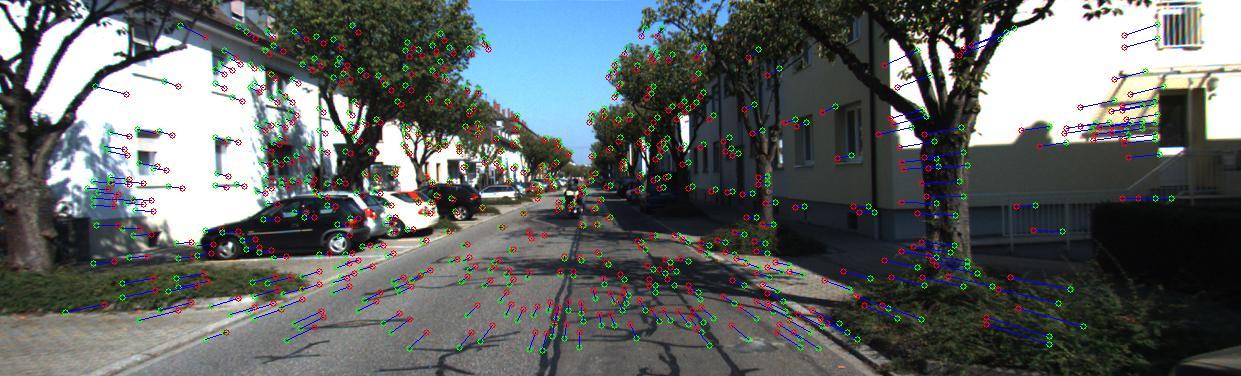

pose_xyz [ 0.36594297 -0.23673095 -8.96104342]
pose_xyz [ 0.40406797 -0.28582664 -7.96297724]
pose_xyz [ 0.39016493 -0.26796006 -8.96272096]
pose_xyz [ 0.48305461 -0.25832248 -9.95835072]
pose_xyz [ 0.46054404 -0.44370027 -8.97594126]
pose_xyz [ 0.44883455 -0.32529146 -9.96883714]
pose_xyz [  0.51699709  -0.40910383 -10.96298469]
pose_xyz [ 0.5531877  -0.52892706 -9.9708493 ]
pose_xyz [  0.60622541  -0.57815962 -10.96822744]
pose_xyz [ 0.61608051 -0.67069542 -9.97256686]
pose_xyz [  0.63209324  -0.58579393 -10.96882753]
pose_xyz [  0.6642592   -0.60241798 -11.96817181]
pose_xyz [  0.65422908  -0.58662649 -10.96834681]
pose_xyz [ 0.59356923 -0.61748224 -9.97066535]
pose_xyz [ 0.5392822  -0.71190242 -8.97661417]
pose_xyz [ 0.54386798 -0.74993308 -7.97734812]
pose_xyz [ 0.56407686 -0.66067264 -8.9731514 ]
pose_xyz [ 0.53750841 -0.58999307 -9.97029658]
pose_xyz [  0.53505064  -0.52998259 -10.9684913 ]
pose_xyz [  0.59206626  -0.60289292 -11.96419874]
pose_xyz [  0.65174242  -0.69212021 -12

In [18]:
cap = None
if KITTI == False:
    cap = cv2.VideoCapture(input)

last = None
last_corners = None
# last_keypoints = None
last_kps = None
last_descriptors = None

R_abs = np.eye(3)
t_abs = np.zeros(3)
last_R = np.eye(3)
last_t = np.zeros(3)
t_abs_all = []
t_abs_gt = []
last_norm_pairs = None
point_cloud = None
last_proj = None
pose_abs = np.eye(4)

i = 0
%matplotlib widget
while (KITTI == True and i < len(train_image_names)) or (cap is not None and cap.isOpened()):
    t0 = time.time()
    ret, im_original, label = None, None, None
    if KITTI == True:
        ret, im_original, label = True, cv2.imread(data_folder + train_image_names[i]), train_labels[i]
    else:
        ret, im_original = cap.read()

    if ret:
        im = im_original
        im = cv2.resize(im_original, (640, 480))
        multiplier_x = im_original.shape[1] / im.shape[1]
        multiplier_y = im_original.shape[0] / im.shape[0]
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        H, W = im.shape
        # print('(H, W)', H, W)
        
        if last is not None:
            im1 = im
            im2 = last

            corners = cv2.goodFeaturesToTrack(
                im1,
                3000,
                0.001,
                6
            )
            
            key_points1 = [cv2.KeyPoint(x=x[0][0], y=x[0][1], size=20) for x in corners]
            kps, descriptors = orb.compute(im1, key_points1)

            result = match_frames(im1, im2, corners, last_corners, kps, last_kps, descriptors, last_descriptors)
            if result is not None:
                norm_pairs, feature_pairs, F, K, indices = result
                # norm_pairs, feature_pairs, K, indices = result

                try:
                    # E, _ = cv2.findEssentialMat(norm_pairs[:, 0], norm_pairs[:, 1], 525, (640, 480), cv2.RANSAC)
                    # F, _ = cv2.findFundamentalMat(norm_pairs[:, 0], norm_pairs[:, 1], cv2.FM_LMEDS)
                    _, R_1, t_1, _ = cv2.recoverPose(F, norm_pairs[:, 0], norm_pairs[:, 1])
                    # F = np.ones((3, 3))
                    pose4d = extract_pose(F)
                    # print('pose4d', pose4d)
                    # print(pose4d)
                    # pose = np.linalg.inv(pose4d)
                    t = pose4d[:3, 3]
                    R = pose4d[:3, :3]
                    # pose_abs = np.dot(pose4d, pose_abs)
                    # print('pose_abs', pose_abs)
                    # pose = pose_abs[:4] / pose_abs[3, 3]
                    # pose_xyz = np.linalg.inv(pose_abs)[:, 3][:-1]
                    # print('pose_xyz', pose_xyz)
                    # pdb.set_trace()
                    
                    # print(pose.shape)
                    # print(pose)
                    # pose_xyz = np.linalg.inv(pose_abs)[:3, 3]
                    
                    # pose_R = np.linalg.inv(pose4d)[:3, :3]
                    # pdb.set_trace()
                    # print(pose4d)
                    
                    R_abs = np.dot(pose_R, R_abs)
                    # Rt = np.eye(4)
                    # Rt[:3, :3] = pose_R
                    # Rt[:3, 3] = pose_xyz.T
                    t_abs = (t_abs + R_abs.dot(pose4d[:3, 3]))
                    # print('t_abs', t_abs)
                    print('pose_xyz', t_abs)
                    # if i > 1:
                    # pdb.set_trace()
                    # print(t_abs)
                    t_abs_all.append(t_abs)

                    # pose_abs = np.dot(pose, pose_abs)
                    # print(pose.shape)
                    # t_abs_all.append(pose_abs[:3, 3])

                    if KITTI == True:
                        t_abs_gt.append(label[:3, 3])

                    # KK = np.eye(4)
                    # KK[:3, :3] = K
                    
                    Rt = np.eye(4)
                    proj1 = Rt

                    if last_proj is not None:
                        # Rt = np.eye(4)
                        # Rt[:3, :3] = pose_R
                        # Rt[:3, 3] = pose_xyz.T
                        # RT = fundamentalToRt(pose_R, pose_xyz)
                        # Rt = pose4d
                        proj1 = np.dot(pose4d, last_proj)

                        k1 = []
                        k2 = []
                        
                        if last_norm_pairs is not None:
                            for index_pair in indices:
                                a, b = index_pair
                                Kinv = np.linalg.inv(K)
                                k1.append(normalize(Kinv, kps[a].pt))
                                k2.append(normalize(Kinv, last_kps[b].pt))
                            
                            kps1 = np.array(k1)
                            kps2 = np.array(k2)

                            points4d = triangulate_geohot(proj1[:3, :4], last_proj[:3, :4], kps1, kps2)
                            # print(points4d.shape)
                            points3d = (points4d / points4d[:, 3:])[:, :3]

                            if point_cloud is None:
                                point_cloud = points3d.reshape(-1, 3)
                            else:
                                point_cloud = np.concatenate([point_cloud, points3d.reshape(-1, 3)]).reshape(-1, 3)
                    
                    last_proj = proj1
                            
                    last_norm_pairs = norm_pairs

                    
                    for pt1, pt2 in feature_pairs:
                        u1,v1 = int(round(pt1[0]) * multiplier_x), int(round(pt1[1]) * multiplier_y)
                        u2,v2 = int(round(pt2[0]) * multiplier_x), int(round(pt2[1]) * multiplier_y)
                        cv2.circle(im_original, (u1, v1), color=(0, 255, 0), radius=3)
                        cv2.line(im_original, (u1, v1), (u2, v2), color=(255, 0, 0))
                        cv2.circle(im_original, (u2, v2), color=(0, 0, 255), radius=3)

                except ValueError as error:
                    print('error', error)

        last = im
        if last_corners is None:
            last_corners = cv2.goodFeaturesToTrack(
                im,
                3000,
                0.001,
                9
            )
            
            keypoints = [cv2.KeyPoint(x=x[0][0], y=x[0][1], size=20) for x in last_corners]
            last_kps, last_descriptors = orb.compute(im, keypoints)
        else:
            last_corners = corners
            last_kps, last_descriptors = kps, descriptors

        cv2.imshow('im1', im_original)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break

        if (i > 100 and i % 1000 == 0) or (i > 0 and i < 11 and i % 10 == 0):
            display_mat(cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB))

        t1 = time.time()
        # print('fps: ', 1 / (t1 - t0))


        i += 1

    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(4)
if KITTI == False:
    cap.release()

## Red vs Green
Red is the ground truth pose and green is the predicted pose of the camera.

(117337, 3)
(75545, 3)
(119, 3)


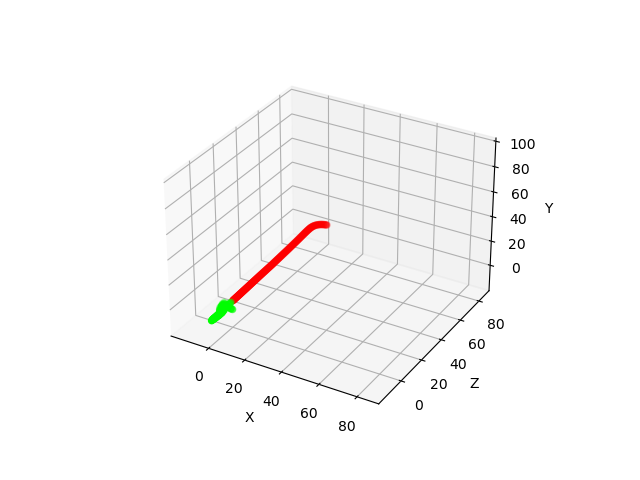

In [19]:
t_abs_all = np.array(t_abs_all).reshape(-1, 3)
if KITTI == True:
    t_abs_gt = np.array(t_abs_gt)
# plt.plot(t_abs_all[:,2], t_abs_all[:,0])
# plt.show()
%matplotlib widget
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax2 = fig.add_subplot(projection='3d')
# pt = (t_abs_all[0, 0], t_abs_all[0, 1], t_abs_all[0, 2])
ax.scatter(t_abs_all[:, 0], t_abs_all[:, 2], t_abs_all[:, 1], color=[(0, 1, 0)])
if point_cloud is not None:
    # print(point_cloud.shape)
    # point_cloud[point_cloud < 0] = -100
    
    # print(point_cloud)
    
    # point_cloud = np.array(random.sample(point_cloud,1000)).reshape(-1, 3)

    r = 0
    # for point in point_cloud:
    #     if point[2] > 0 and r % 1 == 0:
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 2], point_cloud[:, 1], color=[(0, 0, 1)], s=0.0125)
    import open3d as o3d

    pcd = o3d.geometry.PointCloud()
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    ret = np.array(pcd.cluster_dbscan(eps=0.5, min_points=3))

    # print(ret.shape)
    print(point_cloud.shape)
    
    print(point_cloud[ret > 0].shape)
    print(t_abs_all.shape)
    # all_points = np.concatenate([point_cloud[ret > 0], t_abs_all, t_abs_gt])
    all_points = np.concatenate([point_cloud[ret > -1], t_abs_all])
    
    pcd.points = o3d.utility.Vector3dVector(all_points)

    red = [255, 0, 0]
    green = [0, 255, 0]
    blue = [0, 0, 255]
    purple = [255, 0, 255]
    orange = [255, 255, 0]
    color_palette = [red, orange, blue, purple]
    cluster_colors = {}

    for n in set(ret):
        cluster_colors[n] = color_palette[np.random.randint(len(color_palette))]

    colors = np.ndarray(all_points.shape)

    # for i, color in enumerate(colors):
    #     colors[i] = cluster_colors[ret[i]]
    # colors[:point_cloud[ret>-1].shape[0]] = red
    colors[point_cloud[ret>-1].shape[0]:point_cloud[ret>-1].shape[0]+t_abs_all.shape[0]] = green
    # colors[point_cloud[ret>0].shape[0]+t_abs_all.shape[0]:] = blue
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # downpcd = pcd.voxel_down_sample(voxel_size=0.5)
    # ret = np.asarray(point_cloud).flatten()[ret]

    o3d.io.write_point_cloud("pointcloud_clustered.pcd", pcd)
    # with open('pointcloud.txt', 'w') as f:
    #     for point in point_cloud:
    #         f.write(str(point[0]) + ',' + str(point[1]) + ',' + str(point[2]) + '\n')

    # mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, 0.5)
    # mesh.compute_vertex_normals()
    
    # o3d.io.write_triangle_mesh("mesh.obj", mesh)

maximum = None
minimum = None

if KITTI == True:
    ax.scatter(t_abs_gt[:, 0], t_abs_gt[:, 2], t_abs_gt[:, 1], color=(1, 0, 0))
    minimum = np.array(np.concatenate([t_abs_all, t_abs_gt])).min()
    maximum = np.array(np.concatenate([t_abs_all, t_abs_gt])).max()
else:
    minimum = np.array(t_abs_all).min()
    maximum = np.array(t_abs_all).max()
    
# ax.set_zscale(lower=minimum, upper=maxiumum, value=)
ax.set_xlim([minimum, maximum])
ax.set_ylim([minimum, maximum])
ax.set_zlim([minimum, 100])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
# plt.plot(t_abs_all[:, 0], t_abs_all[:, 1], t_abs_all[:, 2])
plt.show()

